In [39]:
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, add_messages, START, END
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [29]:
load_dotenv(override=True)

True

In [30]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()

In [31]:
tool_web_search = Tool(
        name="web_search",
        func=serper.run,
        description="Useful for when you need more information from an online search",
    )
tools = [tool_web_search]

In [32]:

# Step 1: Define the State object

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [33]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [34]:
llm = ChatOpenAI(model="gpt-5-mini", temperature=0.2)

In [35]:
llm_with_tools = llm.bind_tools(tools)

In [36]:
def aws_compute_domain_architect(state: State) -> State:
    """
    This function is used to architect the AWS compute domain.
    """
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [37]:
memory = MemorySaver()

In [38]:
web_search_tool_node = ToolNode(tools=tools)

In [40]:
graph_builder.add_node("aws_compute_domain_architect", aws_compute_domain_architect)
graph_builder.add_node("web_search_tool_node", web_search_tool_node)

graph_builder.add_edge(START, "aws_compute_domain_architect")
graph_builder.add_conditional_edges("aws_compute_domain_architect", tools_condition, ["web_search_tool_node", END])

graph = graph_builder.compile()

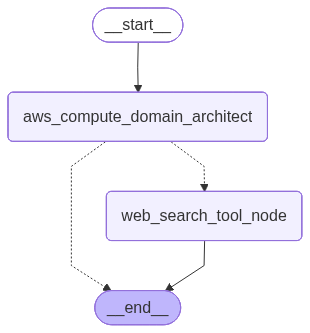

In [41]:
graph